# 3. Visualization

In this notebook we will discover the insights of our dataset and based on learned visualisation principles we will compose several graphs. These plots will be used for final report.

## Firstly lets setup our visualization styles

In [1]:
from functions import *

plt.style.use('seaborn-v0_8-whitegrid')

COLORS = {
    'pv': '#FFD700', #kollane
    'demand': '#1E90FF', # oranž
    'price': '#237823', # roheline
    'weather': '#FF8C00', # sinine
    'neutral': '#555555' # hall
}
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlelocation'] = 'left'
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['xtick.color'] = '#333333'
mpl.rcParams['ytick.color'] = '#333333'
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['axes.labelcolor'] = '#333333'
mpl.rcParams['axes.titlelocation'] = 'left'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['legend.framealpha'] = 0.9
mpl.rcParams['legend.edgecolor'] = '#444'

# Seaborn värviteema ja legendi stiil
sns.set_palette([COLORS['pv'], COLORS['demand'], COLORS['price']])
sns.set_style("whitegrid")

## Load the data and add some extra fields

In [3]:
df = load_data()
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_name()
df['is_weekend'] = df.index.dayofweek >= 5
df['month'] = df.index.month

df['season'] = df['month'].map(get_season)

df.head()

,pv_mod1,pv_mod2,pv_mod3,demand,pv,price,temperature,pressure (hPa),cloud_cover (%),cloud_cover_low (%),...,wind_speed_10m (km/h),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),hour,day_of_week,is_weekend,month,season
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-07-01 00:00:00+00:00,0.0,0.0,0.0,0.27,0.0,0.01605,13.5,1011.3,4,0,...,10.5,NaN,0,0,0.0,0,Monday,False,7,Summer
2013-07-01 01:00:00+00:00,0.0,0.0,0.0,0.23,0.0,0.00095,13.2,1010.8,27,1,...,11.9,0.0,0,0,0.0,1,Monday,False,7,Summer
2013-07-01 02:00:00+00:00,0.0,0.0,0.0,0.26,0.0,0.00060,13.1,1010.3,33,0,...,11.6,0.0,0,0,0.0,2,Monday,False,7,Summer
2013-07-01 03:00:00+00:00,0.0,0.0,0.0,0.28,0.0,0.00046,13.0,1010.3,28,0,...,11.2,NaN,2,7,30.1,3,Monday,False,7,Summer
2013-07-01 04:00:00+00:00,0.0,0.0,0.0,0.29,0.0,0.00046,13.8,1010.2,16,0,...,11.7,NaN,30,31,252.0,4,Monday,False,7,Summer


First of all lets plot PV, Demand and price over few days.

In [4]:
period_start = df.index.min()
period_end = period_start + pd.Timedelta(days=7)
subset = df.loc[period_start:period_end]

table = df[['pv', 'demand', 'price']].describe().T.round(2)
save_table(table, 'ex3_summary_table.csv')

,count,mean,std,min,25%,50%,75%,max
pv,8759.0,0.66,1.11,0.0,0.00,0.00,0.82,4.81
demand,8759.0,0.53,0.38,0.0,0.28,0.38,0.66,4.24
price,8759.0,0.05,0.03,0.0,0.03,0.05,0.06,0.26


## Figure 1. PV, demand and price comparison

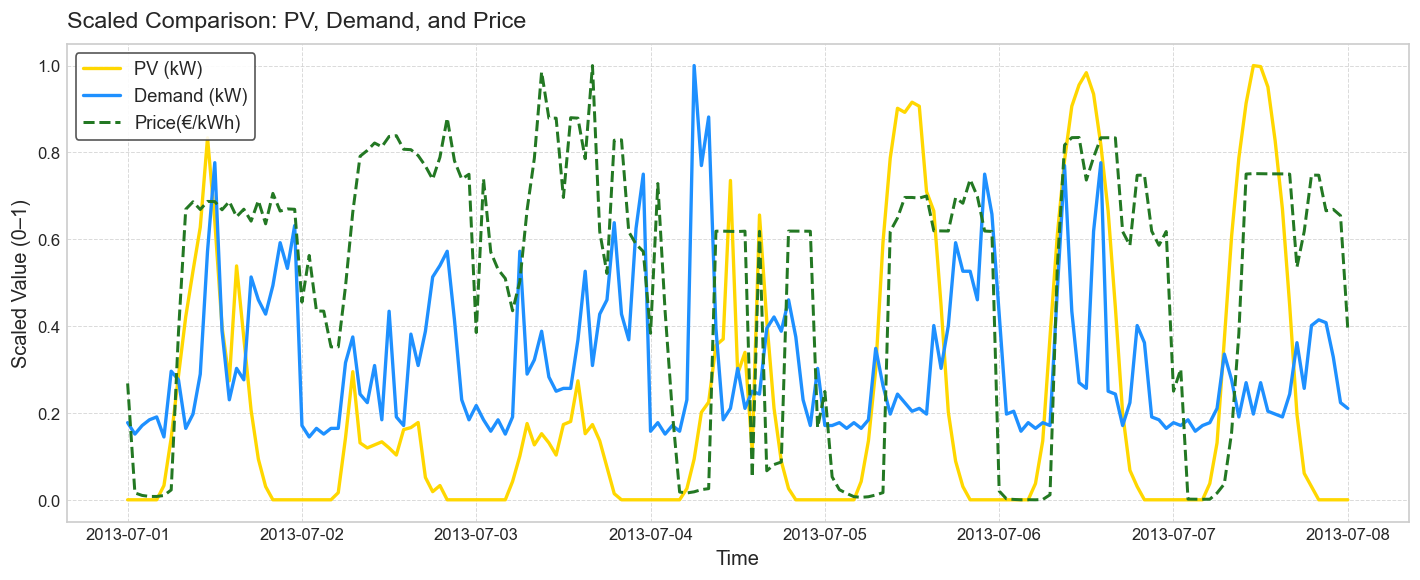

In [5]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(subset.index, subset['pv'] / subset['pv'].max(),
        label='PV (kW)', color=COLORS['pv'], linewidth=2)
ax.plot(subset.index, subset['demand'] / subset['demand'].max(),
        label='Demand (kW)', color=COLORS['demand'], linewidth=2)
ax.plot(subset.index, subset['price'] / subset['price'].max(),
        label='Price(€/kWh)', color=COLORS['price'],
        linewidth=1.8, linestyle='--')

ax.set_title("Scaled Comparison: PV, Demand, and Price", fontsize=14, pad=10)
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Scaled Value (0–1)", fontsize=12)

ax.legend(frameon=True, loc='upper left', facecolor='white', framealpha=0.9, edgecolor='#444', fontsize=11)

ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
ax.tick_params(axis='x', labelsize=10, rotation=0)
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
save_fig(fig, "ex3_fig1_timeseries_pv_demand_price_scaled.svg")
plt.show()

**Figure 1. Scaled comparison of PV generation, electricity demand, and price.**

All three variables are scaled to a common 0–1 range to make their daily patterns directly comparable.
The figure shows that PV generation peaks during midday when sunlight is available, while electricity demand increases in the evening.
Price follows its own pattern, fluctuating independently of PV and demand.


## Figure 2. Daily profile weekday vs weekend


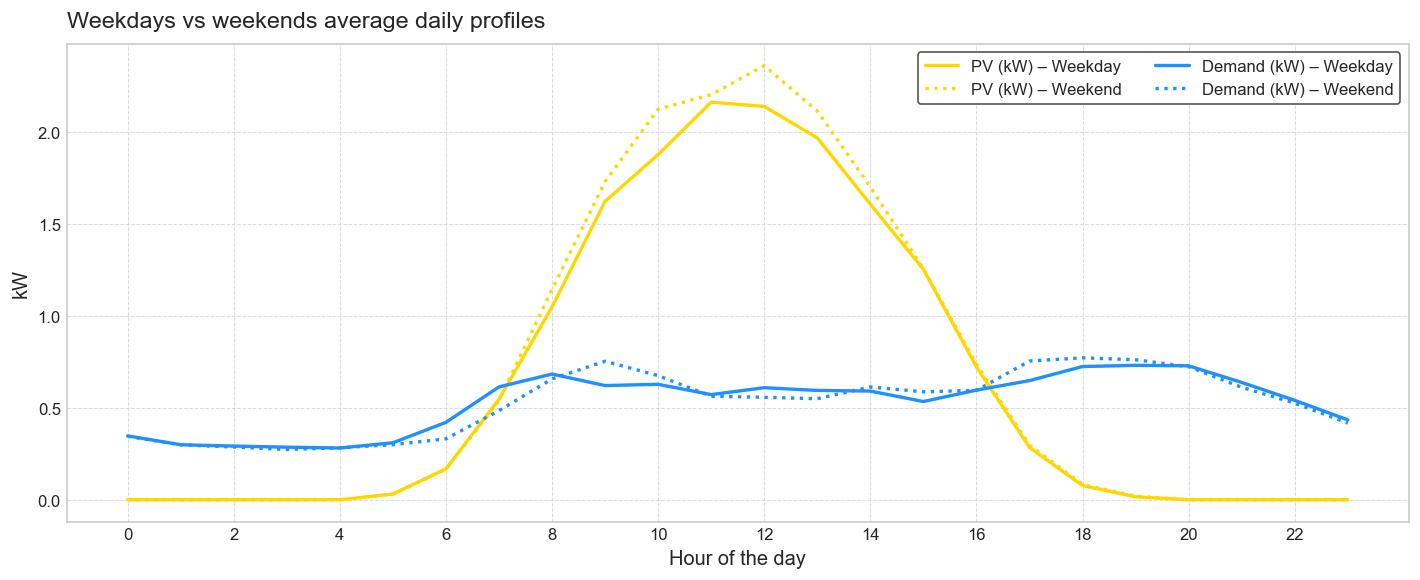

In [73]:
hourly_mean = df.groupby(['is_weekend', 'hour']).mean(numeric_only=True).reset_index()
weekday= hourly_mean[hourly_mean['is_weekend'] == False]
weekend = hourly_mean[hourly_mean['is_weekend'] == True]
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(weekday['hour'], weekday['pv'],
        label='PV (kW) – Weekday', color=COLORS['pv'], linewidth=2.0)
ax.plot(weekend['hour'], weekend['pv'],
        label='PV (kW) – Weekend', color=COLORS['pv'], linewidth=2.0, linestyle='dotted')
ax.plot(weekday['hour'], weekday['demand'],
        label='Demand (kW) – Weekday', color=COLORS['demand'], linewidth=2.0)
ax.plot(weekend['hour'], weekend['demand'],
        label='Demand (kW) – Weekend', color=COLORS['demand'], linewidth=2.0, linestyle='dotted')
ax.set_title("Weekdays vs weekends average daily profiles", fontsize=14, pad=10)
ax.set_xlabel("Hour of the day", fontsize=12)
ax.set_ylabel("kW", fontsize=12)
ax.legend(frameon=True, loc='upper right', facecolor='white', framealpha=0.9, edgecolor='#444', fontsize=10, ncol=2)
ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
ax.set_xticks(range(0, 24, 2))
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
plt.tight_layout()
save_fig(fig, "ex3_fig2_avg_daily_profile_weekday_weekend.svg")
plt.show()


**Figure 2. Average daily profiles for weekdays and weekends**

The figure compares typical hourly patterns of PV generation, electricity demand, and price between weekdays and weekends.
PV generation peaks around midday in both cases, while demand is higher during the evening on weekdays and more balanced on weekends.


## Figure 3. Daily profile winter vs summer

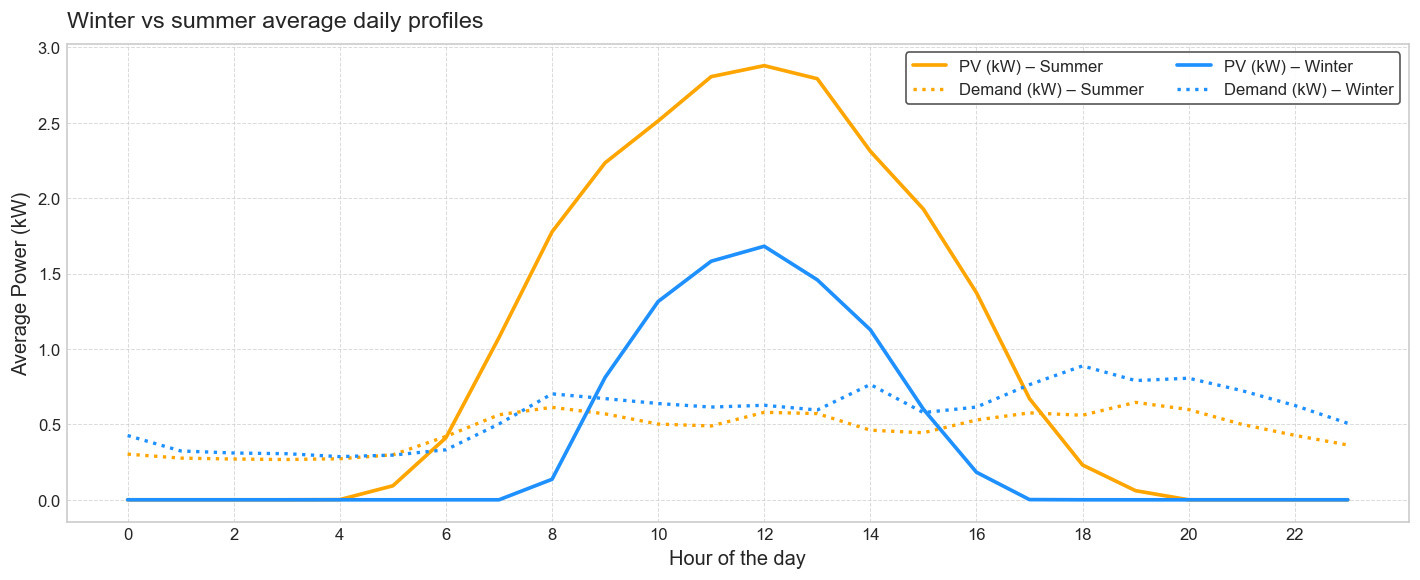

In [74]:
hourly_season = df.groupby(['season', 'hour']).mean(numeric_only=True).reset_index()
seasons_to_plot = ['Summer', 'Winter']
season_colors = {'Summer': '#FFA500', 'Winter': '#1E90FF'}
fig, ax = plt.subplots(figsize=(12, 5))
for season in seasons_to_plot:
    data = hourly_season[hourly_season['season'] == season]
    ax.plot(data['hour'], data['pv'],
            label=f'PV (kW) – {season}',
            color=season_colors[season], linewidth=2.2)
    ax.plot(data['hour'], data['demand'],
            label=f'Demand (kW) – {season}',
            color=season_colors[season], linewidth=2.0, linestyle='dotted')
ax.set_title("Winter vs summer average daily profiles", fontsize=14, pad=10)
ax.set_xlabel("Hour of the day", fontsize=12)
ax.set_ylabel("Average Power (kW)", fontsize=12)
ax.legend(frameon=True, loc='upper right', facecolor='white', framealpha=0.9,
          edgecolor='#444', fontsize=10, ncol=2)
ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
ax.set_xticks(range(0, 24, 2))
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
plt.tight_layout()
save_fig(fig, "ex3_fig3_avg_daily_profile_summer_winter.svg")
plt.show()

**Figure 3. Average daily profiles of PV generation and electricity demand for summer and winter**

The figure compares typical daily energy patterns between summer and winter.
During summer, PV generation is much higher and extends over a longer period, while electricity demand stays relatively low and stable.
In winter, PV generation is limited to a few midday hours, but electricity demand is higher throughout the day.
This contrast illustrates the seasonal imbalance between energy supply and demand, which highlights the need for energy storage and smart control in HEMS.

## Figure 4. Demand and PV variability

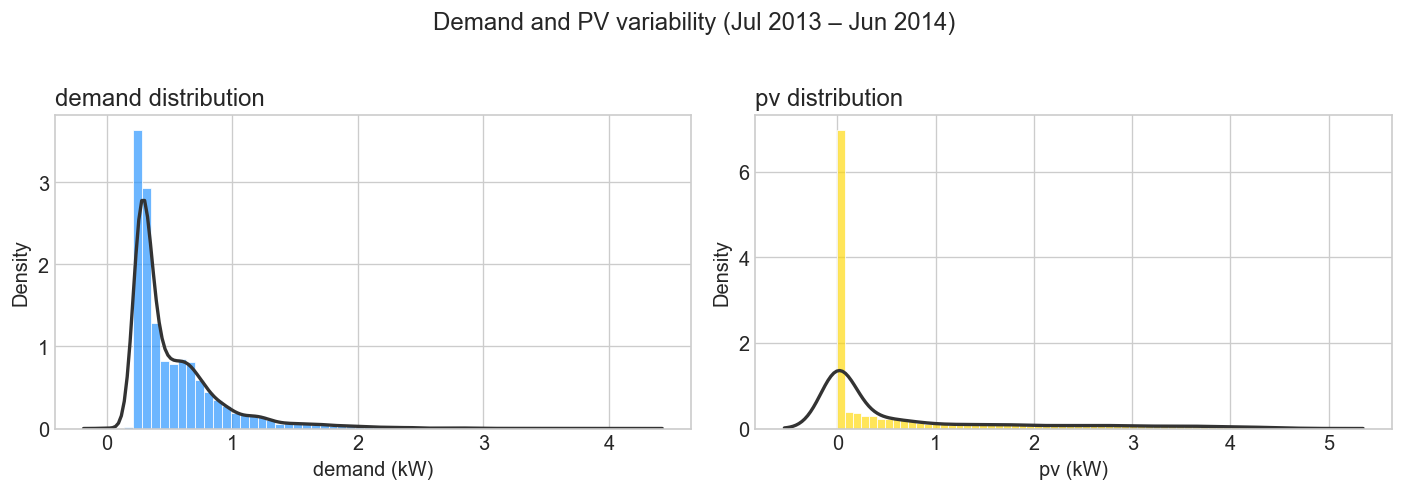

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, column, color in zip(axes, ['demand', 'pv'], [COLORS['demand'], COLORS['pv']]):
    sns.histplot(df[column], bins=60, stat='density', color=color, alpha=0.65, edgecolor='white', ax=ax)
    sns.kdeplot(df[column], color='#333333', linewidth=2, ax=ax)
    ax.set_title(f'{column} distribution')
    ax.set_xlabel(f'{column} (kW)')
    ax.set_ylabel('Density')
fig.suptitle('Demand and PV variability (Jul 2013 – Jun 2014)', y=1.02)
fig.tight_layout()
save_fig(fig, 'ex3_fig4_distributions.svg')
plt.show()

**Figure 4. Distributions of electricity demand and PV generation (Jul 2013 – Jun 2014).**

The histograms with KDE overlays show how electricity demand and PV generation vary throughout the year.
PV generation has a highly skewed distribution, with many hours of near-zero output and fewer hours of high production, while the demand follows more stable pattern.

## Figure 5. Correlation heatmap

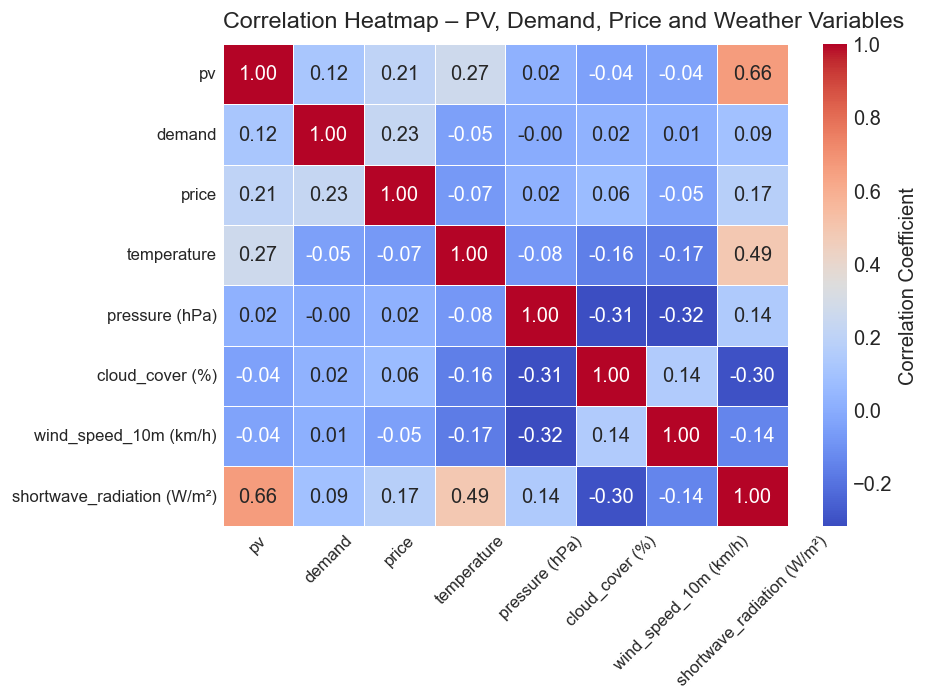

In [76]:
corr_vars = [
    'pv',
    'demand',
    'price',
    'temperature',
    'pressure (hPa)',
    'cloud_cover (%)',
    'wind_speed_10m (km/h)',
    'shortwave_radiation (W/m²)'
]
corr = df[corr_vars].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'}, ax=ax)

ax.set_title("Correlation Heatmap – PV, Demand, Price and Weather Variables", fontsize=14, pad=10)
ax.tick_params(axis='x', rotation=45, labelsize=10)
ax.tick_params(axis='y', rotation=0, labelsize=10)

plt.tight_layout()
save_fig(fig, "ex3_fig5_correlation_heatmap.svg")
plt.show()

**Figure 5. Correlation heatmap of PV generation, electricity demand, price, and weather variables.**

The heatmap shows the relationships between most important variables in the dataset.
PV generation is strongly correlated with shortwave radiation and temperature, and negatively correlated with cloud cover, which means that it depends on weather conditions a lot.